<a href="https://colab.research.google.com/github/gayoooon1/2021-RecSys/blob/main/Matrix_Factorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Matrix Factorization

이번주에는 SVD 사용법을 익히면 좋겠어요. SVD로 결과 까지 나오면 좋겠지만, 단계적으로 접근을 하고자 합니다. SVD가 무엇이고, Truncated SVD를 어떻게 하면 좋은지 한번 읽어보고 자료들도 찾아보세요. 그리고 유튜브에도 강좌가 많을거에요. 우리가 사용할 matrix는 user-item matrix가 됩니다.

## 전처리

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/DEEPLEARNING/ml-1m

/content/drive/MyDrive/DEEPLEARNING/ml-1m


In [ ]:
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings(action='ignore')

In [ ]:
# visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
movies = pd.read_csv('movies.dat', header=None, sep='::', names=["movie_id", "title", "genres"], encoding='latin-1', engine='python')
ratings = pd.read_csv('ratings.dat', header=None, sep='::', names = ['user_id', 'movie_id', 'rating', 'unix_timestamp'], encoding='latin-1', engine='python')
users = pd.read_csv('users.dat',  header=None, sep='::', names=['user_id', 'sex', 'age', 'occupation', 'zip_code'],encoding='latin-1', engine='python', index_col = 'user_id')

## User 전처리

In [ ]:
users.isnull().sum()

sex           0
age           0
occupation    0
zip_code      0
dtype: int64

In [ ]:
sex_mapping = {'M':0, 'F':1}
users['sex'] = users['sex'].map(sex_mapping)
users.head()

,sex,age,occupation,zip_code
user_id,,,,
1,1,1,10,48067
2,0,56,16,70072
3,0,25,15,55117
4,0,45,7,02460
5,0,25,20,55455


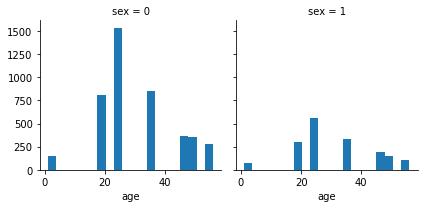

In [ ]:
g = sns.FacetGrid(users, col = 'sex')
g.map(plt.hist, 'age', bins=20)

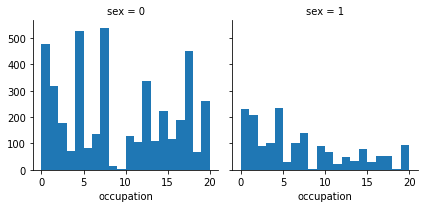

In [ ]:
g = sns.FacetGrid(users, col = 'sex')
g.map(plt.hist, 'occupation', bins=20)

나이를 크게 0-20, 20-40, 40- 이렇게 나눌 수 있겠다.

In [ ]:
users.drop('zip_code', axis=1, inplace=True)

In [ ]:
def age_detect(n):
  if (n>0) & (n<21):
    n=0
    return n
  elif (n>20) & (n<41):
    n=1
    return n
  else: 
     n=2
     return n

In [ ]:
users['age'] = users['age'].apply(age_detect)

In [ ]:
users.head()

,sex,age,occupation
user_id,,,
1,1,0,10
2,0,2,16
3,0,1,15
4,0,2,7
5,0,1,20


## Ratings 전처리

In [ ]:
ratings = ratings[ratings['rating']>2]
ratings.drop('unix_timestamp',axis=1, inplace=True)

In [ ]:
ratings.rating = 1

## Train, Test Split

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(ratings, test_size = 0.05, random_state = 42)

## Group

In [ ]:
group_base = pd.merge(train,users, on='user_id')

In [ ]:
group_base.set_index('user_id')

,movie_id,rating,sex,age,occupation
user_id,,,,,
3697,16,1,0,1,15
3697,1387,1,0,1,15
3697,2140,1,0,1,15
3697,2694,1,0,1,15
3697,2701,1,0,1,15
...,...,...,...,...,...
572,3623,1,0,0,4
572,3408,1,0,0,4
572,3861,1,0,0,4


In [ ]:
# age 0,1,2
# sex 0,1
# total 6 경우의 수
m_low = group_base[(group_base['age']==0) & group_base['sex']==0].groupby('movie_id').size().sort_values(ascending=False).index[:50].tolist()
f_low = group_base[(group_base['age']==0) & group_base['sex']==1].groupby('movie_id').size().sort_values(ascending=False).index[:50].tolist()
m_mid = group_base[(group_base['age']==1) & group_base['sex']==0].groupby('movie_id').size().sort_values(ascending=False).index[:50].tolist()
f_mid = group_base[(group_base['age']==1) & group_base['sex']==1].groupby('movie_id').size().sort_values(ascending=False).index[:50].tolist()
m_high = group_base[(group_base['age']==2) & group_base['sex']==0].groupby('movie_id').size().sort_values(ascending=False).index[:50].tolist()
f_high =  group_base[(group_base['age']==2) & group_base['sex']==1].groupby('movie_id').size().sort_values(ascending=False).index[:50].tolist()

In [ ]:
group_test = pd.merge(test,users, on='user_id')
group_test.drop('occupation',axis=1,inplace=True)
group_test.head()

,user_id,movie_id,rating,sex,age
0,1141,596,1,1,1
1,1141,926,1,1,1
2,1141,3897,1,1,1
3,1141,933,1,1,1
4,1141,1073,1,1,1


In [ ]:
group_test.drop('rating',axis=1,inplace=True)

In [ ]:
group_test.set_index('user_id')

,movie_id,sex,age
user_id,,,
1141,596,1,1
1141,926,1,1
1141,3897,1,1
1141,933,1,1
1141,1073,1,1
...,...,...,...
1508,2028,1,0
2925,3753,1,1
4545,2571,0,1


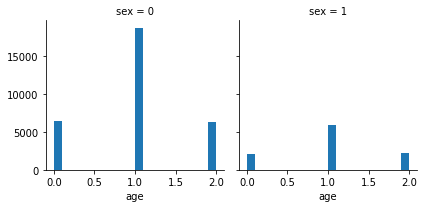

In [ ]:
g = sns.FacetGrid(group_test, col = 'sex')
g.map(plt.hist, 'age', bins=20)

In [ ]:
#group_test[(group_test['age']==0) & (group_test['sex']==0)]['movie_id'].tolist()

In [ ]:
tml = group_test[(group_test['age']==0) & (group_test['sex']==0)]['movie_id'].tolist()
tfl = group_test[(group_test['age']==0) & (group_test['sex']==1)]['movie_id'].tolist()
tmm = group_test[(group_test['age']==1) & (group_test['sex']==0)]['movie_id'].tolist()
tfm = group_test[(group_test['age']==1) & (group_test['sex']==1)]['movie_id'].tolist()
tmh = group_test[(group_test['age']==2) & (group_test['sex']==0)]['movie_id'].tolist()
tfh =  group_test[(group_test['age']==2) & (group_test['sex']==1)]['movie_id'].tolist()

In [ ]:
len(tml) + len(tfl) + len(tmm) +len(tfm)+len(tmh)+len(tfh)

41824

In [ ]:
len(group_test)

41824

In [ ]:
def hitrate50_group():
  hit = 0
  for a in tml:
    if a in m_low:
      hit +=1
  for b in tfl:
    if b in f_low:
      hit +=1
  for c in tmm:
    if c in m_mid:
      hit +=1
  for d in tfm:
    if d in f_mid:
      hit +=1
  for e in tmh:
    if e in m_high:
      hit +=1
  for f in tfh:
    if f in f_high:
      hit +=1
  return ((hit/len(group_test))) * 100

In [ ]:
print('%.2f%%' %(hitrate50_group()))

12.84%


Grouping 결과 12.84% 예측 🙄.............   
age를 시각화해서 나뉘어지는 3범주로 0,1,2로 나누었고, sex 0,1 두 범주로 나누어 총 6가지 경우의 수를 가지고 가장 많이 본 영화 top 50 추출, test set에 적용하였음

## Genre

In [ ]:
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
# The movies file contains a binary feature for each genre.
genre_cols = [
    "Action", "Adventure", "Animation", "Children's", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]

In [ ]:
genres_unique = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre']) # Format into DataFrame to store later
movies = movies.join(movies.genres.str.get_dummies().astype(bool))

In [ ]:
movies.genres = movies.genres.str.split('|')

In [ ]:
for a in genre_cols:
  movies[a] = movies[a].replace({True: 1, False: 0})

In [ ]:
movies.head()

,movie_id,title,genres,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),"[Animation, Children's, Comedy]",0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]",0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),"[Comedy, Drama]",0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),[Comedy],0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
train.set_index('user_id')
train.drop('rating', axis=1, inplace=True)
train = pd.merge(train, movies, on='movie_id')

In [ ]:
train[train['user_id']==3697].groupby('Adventure').size()

Adventure
0    73
1    43
dtype: int64

In [ ]:
def rec_movies(uid):
  favg = dict()
  for a in genre_cols:
    try: favg[a] = train[train['user_id']==uid].groupby(a).size()[1]
    except KeyError: continue
  favgl = sorted(favg, key=favg.get, reverse=True)[:5]
  ranking = []
  for a in favgl:
    ranking.append(train[train[a]==1].groupby('movie_id').size().sort_values(ascending=False)[:10].tolist())
  return sum(ranking, [])

In [ ]:
test = test[['user_id', 'movie_id']]
test = test.set_index('user_id')

In [ ]:
def find_watched_list(uid):
  for a in test['movie_id'].groupby('user_id'):
    if a[0] == uid:
      return a[1].tolist()

In [ ]:
def hitrate50_genre(df):
  hit = 0
  for tmp in df.index:
    rec_list = rec_movies(tmp)
    watch = find_watched_list(tmp)
    for e in watch:
      if e in rec_list:
        hit+=1
  print(hit)
  return (hit/len(test)) * 100

In [ ]:
print('%.2f%%' %(hitrate50_genre(test)))

7438
17.78%


장르의 경우 지난 주의 것보다 조금 더 보완해서 진행, 장르를 unique하게 모두 자르고 유저가 좋아하는 장르 5개를 고른뒤 각 장르별 많이 본 영화를 10개씩 추천한 뒤(총 50개) 유저가 실제로 본 영화와 얼마나 매치하는지 hit을 계산했다 😊 

## Popular

In [ ]:
top_50 = train.groupby('movie_id').size().sort_values(ascending=False).index[:50].tolist()

In [ ]:
movie_list = test['movie_id'].tolist()

In [ ]:
def hitrate50_popular():
  hit = 0
  for a in movie_list:
    if a in top_50:
      hit+=1
  return (hit/len(movie_list)) * 100

In [ ]:
print('%.2f%%' %(hitrate50_popular()))

12.50%


## Conclusion   
group : 12.84%   
genre : 17.78%   
popular : 12.50%   

genre > group > popular 순으로 정확도가 높은 것을 알 수 있었다. 하지만 장르 추천 시스템은 돌리는데 시간이 엄청 오래걸렸다...🤔

# Matrix Factorization   
[Matrix Factorization 요약정리 🔎](https://silly-force-8ba.notion.site/Matrix-Factorization-bb6dd272c39e4428ac2805cd8d3b339b)

## Surprise Package

In [ ]:
pip install scikit-surprise

In [ ]:
from surprise import SVD
from surprise import accuracy
from surprise import Reader
from surprise import Dataset
from surprise import BaselineOnly
import surprise

### SVD

Surprise 패키지의 경우 train, test 데이터를 임의로 지정했을 때 돌리기가 조금 까다로운 편이었다. surprise github issues에서 찾은 바로는 test데이터를 iterate 하면서 각각 사용자, 아이템을 predict 하게 하거나 (근데 시간이 오래 걸릴듯) 따로 test를 더미로 만들어서 전처리하고 예측하도록 했음   
[Using Surprise to make predictoins on Dataframe or Dataset](https://github.com/NicolasHug/Surprise/issues/215)

In [ ]:
algo = SVD()

In [ ]:
#reader = Reader(rating_scale=(0,1))
#train = Dataset.load_from_df(train[['user_id', 'movie_id', 'rating']], reader)

In [ ]:
#train = train.build_full_trainset()

In [ ]:
#algo.fit(train)

In [ ]:
#test.loc[:,'rating'] = 0

In [ ]:
#test_processed = Dataset.load_from_df(test[['user_id', 'movie_id', 'rating']], reader)

In [ ]:
#NA, test = surprise.model_selection.split.train_test_split(test_processed, test_size = 1.0, shuffle=False)

In [ ]:
#predictions = algo.test(test)

In [ ]:
#accuracy.rmse(predictions)

### ALS, SGD 기반   

In [ ]:
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)

In [ ]:
algo.fit(train)

Estimating biases using als...


In [ ]:
predictions = algo.test(test)

In [ ]:
accuracy.rmse(predictions)

RMSE: 1.0000


1.0

In [ ]:
print('Using SGD')
bsl_options = {'method': 'sgd',
               'learning_rate': .00005,
               }
algo = BaselineOnly(bsl_options=bsl_options)

Using SGD


In [ ]:
algo.fit(train)

Estimating biases using sgd...


In [ ]:
predictions = algo.test(test)

In [ ]:
accuracy.rmse(predictions)

RMSE: 1.0000


1.0

뭔가 잘못되고 있다고 생각했는데...   
Can Surprise support content-based data or implicit ratings?   

No: this is out of scope for surprise. Surprise was designed for explicit ratings.   😱




## Scipy   
scikit-learn에서도 SVD를 제공하나, U, sigma, V.T를 return 하지 않는다.   
[참조 : 파이썬 Matrix Factorization 영화 추천 시스템(movie recommender system) 구현해보기 - 2](https://lsjsj92.tistory.com/570)

In [ ]:
rating_movies = pd.merge(train, movies, on='movie_id') # title 칼럼 얻을 수 있게 합치기
rating_movies.head()

,user_id,movie_id,rating,title,genres
0,3697,16,3,Casino (1995),Drama|Thriller
1,4607,16,4,Casino (1995),Drama|Thriller
2,1019,16,4,Casino (1995),Drama|Thriller
3,593,16,3,Casino (1995),Drama|Thriller
4,668,16,3,Casino (1995),Drama|Thriller


In [ ]:
rating_matrix = train.pivot_table('rating', index = 'user_id', columns = 'movie_id').fillna(0)
rating_matrix.head()

movie_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,3913,3914,3915,3916,3917,3918,3919,3920,3921,3922,3923,3924,3925,3926,3927,3928,3929,3930,3931,3932,3933,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,4.0,0.0,3.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### SVD

In [ ]:
from scipy import linalg

In [ ]:
U, sigma, Vt = linalg.svd(rating_matrix)

In [ ]:
U.shape

(6039, 6039)

In [ ]:
sigma.shape

(3628,)

In [ ]:
Vt.shape

(3628, 3628)

### Truncated SVD   
상위 k개의 잠재 요인을 모아서 축소 시킨 것

In [ ]:
from scipy.sparse.linalg import svds, eigs

In [ ]:
U, sigma, Vt = svds(rating_matrix, k = 12)

In [ ]:
U.shape # 차원이 축소된 모습을 볼 수 있다! 내가 지정한 k대로

(6039, 12)

In [ ]:
sigma.shape # 0이 아닌 값만 1차원 행렬로 표현된 상태, 0이 포함된 대칭행렬로 변환할 때에는 np.diag 사용 (diagonal)

(12,)

In [ ]:
sigma = np.diag(sigma)

In [ ]:
sigma.shape

(12, 12)

1. user-movie 평점 행렬 사용, implicit 이므로 평균 점수가 없으므로 조정할 필요 X
2. 차원 축소한 SVD 적용했음 (쪼갠 것)
3. sigma를 대칭행렬로 바꿔줌
   
다음 할일은? 다시 원본 행렬로 복구시키기, 강의에서처럼 prediction을 구하는 것 😎

In [ ]:
pred_matrix = np.dot(np.dot(U, sigma), Vt)

In [ ]:
prediction = pd.DataFrame(pred_matrix, columns = rating_matrix.columns, index = rating_matrix.index)
prediction.head()

movie_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,3913,3914,3915,3916,3917,3918,3919,3920,3921,3922,3923,3924,3925,3926,3927,3928,3929,3930,3931,3932,3933,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.938746,0.479019,0.190208,0.055928,0.154845,-0.405188,0.196628,0.115908,-0.070818,0.049253,0.368848,0.025319,0.167913,-0.044499,0.006199,-0.139526,0.604902,0.007999,0.024608,-0.076052,-0.552046,-0.099306,-0.057245,0.084926,0.126779,0.111468,0.063135,0.046946,0.029190,-0.041041,0.087262,0.107620,-0.004114,1.260202,-0.000290,0.486830,0.004252,0.026208,0.285073,0.023156,...,0.018113,0.036654,0.016906,0.279104,-0.061027,-0.037639,-0.036425,-0.045600,0.004137,0.000406,-0.039962,0.008913,-0.147750,-0.015760,-0.029407,0.003080,-0.061019,-0.051950,-0.001407,-0.089983,-0.008289,-0.031960,-0.024293,0.053400,-0.062681,-0.007040,-0.006345,-0.002514,-0.002038,-0.003052,-0.015492,0.002917,0.017654,-0.018641,-0.070408,0.286414,0.068671,-0.012911,0.006083,0.016453
2,1.109222,0.240252,0.194046,0.066219,0.161931,1.011637,0.428836,0.012923,0.086658,0.964677,1.147099,-0.057639,-0.003984,0.118032,0.084587,0.509479,0.908312,-0.071486,0.037164,0.124819,1.087826,0.342475,0.118176,0.216002,0.690086,0.049647,0.013586,0.096522,-0.283031,0.010522,0.126717,0.653860,0.006962,1.009774,0.043724,0.856665,-0.005023,-0.001080,0.398339,0.041627,...,-0.018821,0.007768,0.055644,0.549491,-0.237527,-0.153206,-0.045157,-0.055400,-0.016424,-0.017843,-0.020463,0.001677,-0.091857,0.107785,0.153273,-0.038279,0.052887,-0.076144,-0.009750,-0.043639,-0.002778,0.000209,-0.015775,0.013738,-0.000862,-0.016304,-0.014827,-0.012417,-0.020330,-0.013720,-0.011018,0.002567,-0.005134,0.008362,0.009694,0.382059,-0.028960,0.025656,0.004381,0.317101
3,1.167225,0.110076,0.124693,-0.028969,0.056872,0.267152,0.031399,0.008173,0.006030,0.412596,0.156767,-0.000270,0.001343,-0.083587,0.005462,-0.022159,-0.153868,0.003438,0.053576,0.003834,0.463640,-0.107573,-0.006474,0.002566,-0.056529,-0.030158,-0.016562,-0.096548,-0.077513,-0.057029,-0.046053,-0.037091,0.000661,0.405269,-0.077831,-0.119347,0.001396,0.007974,0.234771,-0.030508,...,-0.000803,-0.046552,-0.032328,0.165131,-0.035868,-0.045381,-0.025057,-0.024081,-0.003777,-0.002526,-0.043625,0.000932,-0.050237,-0.030616,-0.055037,-0.007963,-0.018195,-0.043394,-0.005964,-0.097714,-0.011388,-0.019307,-0.023053,-0.026896,0.000396,-0.005636,-0.005053,-0.005657,-0.005662,-0.005872,-0.002441,-0.000516,0.003117,-0.001494,-0.020383,0.253072,-0.065974,-0.020522,-0.023951,-0.043441
4,0.231585,-0.019126,-0.127971,-0.065215,-0.140680,0.383930,-0.136851,-0.005535,-0.007223,0.283062,-0.253501,-0.048337,-0.012664,-0.080016,-0.019747,-0.025682,0.061912,-0.037024,-0.136134,-0.013424,0.116151,-0.054834,-0.009265,-0.027188,0.002677,-0.031214,-0.030863,0.002531,0.063869,-0.010672,-0.064614,0.131660,0.000261,0.014987,-0.014435,-0.054811,-0.002687,-0.022163,-0.294862,-0.010651,...,-0.008697,-0.014835,-0.006653,0.035548,0.044874,0.010838,-0.000245,-0.004276,-0.008479,-0.009947,-0.011865,-0.002398,-0.041072,-0.005560,-0.002346,-0.025142,-0.028175,0.009401,0.000607,0.007937,-0.001697,-0.002552,-0.001413,0.002885,0.011322,-0.000645,-0.001273,-0.004387,0.000600,-0.001974,-0.018325,-0.003898,-0.002658,-0.011512,-0.002186,-0.043844,-0.037747,-0.005807,-0.011554,-0.014535
5,1.025913,-0.025778,-0.084323,0.051748,-0.098811,1.138708,-0.018205,0.002852,-0.011485,0.111007,0.218093,-0.036093,-0.005404,0.172457,-0.049180,0.955322,0.915103,0.285794,-0.016923,-0.036315,1.059128,0.261477,0.009030,0.223637,1.292800,0.154618,0.023667,0.380390,0.937776,0.196728,0.027561,1.853588,0.002157,1.307976,0.147367,1.301487,0.006747,-0.028156,1.300716,0.048080,...,0.053586,0.120519,0.227780,0.241623,0.193587,0.095150,0.013593,0.143198,-0.007346,0.001745,0.007057,-0.019362,0.243357,-0.08365

In [ ]:
mean_array = np.array(prediction.mean(axis=1))

In [ ]:
mean_array.mean()

0.1421210465846453

In [ ]:
mean_array.shape

(6039,)

In [ ]:
mean_array[0]

0.013596149138959755

### Recall
성능을 두가지로 보면 어떨까 싶은데,   
1. 전체 평균 and 중앙값
2. k를 조정해서 봐도 좋을 것 같다

In [ ]:
test.drop('rating',axis=1,inplace=True)

In [ ]:
test.set_index('user_id', inplace=True)

In [ ]:
def rec_movies(uid):
  movies = []
  for b in prediction.columns:
      prediction.loc[uid][b] > mean_array.mean()
      movies.append(b)
  return movies

In [ ]:
def find_watched_list(uid):
  for a in test['movie_id'].groupby('user_id'):
    if a[0] == uid:
      return a[1].tolist()

In [ ]:
def recall_scipy(test): # train에서 볼 것 같은 영화를 추려서 test에서 실제로 봤는지 확인하기!
  cnt = 0
  for i in test.index:
    rec = rec_movies(i)
    watch = find_watched_list(i)
    cnt += len(set(rec) & set(watch))
  return (cnt/len(test)) *100

In [ ]:
print('%.2f%%' %(recall_scipy(test))) # 3시간 이상이 돌아갔는데 결과값이 나오지 않은ㅁ...ㅠㅠ함수 줄여보자

KeyboardInterrupt: ignored

## Scikit-Learn   
sklearn에도 truncated SVD 모듈이 있었는데, scipy 알고리즘을 포함해서 알고리즘이 2개 였다. 파라미터에 algorithm{‘arpack’, ‘randomized’}, default=’randomized’
SVD solver to use. **Either “arpack” for the ARPACK wrapper in SciPy (scipy.sparse.linalg.svds), or “randomized” for the randomized algorithm due to Halko (2009).** 이렇게 arpack, randomized 두 개 사용가능   
[sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)

[Recommendation System With Implicit Feedback](http://sanghyukchun.github.io/95/)